In [1]:
import pyEX as p
import tributary as t

In [2]:
def sma_close(data):
    dat = [x['close'] for x in data]
    return sum(dat)/len(dat)
    
def crosses(state, data):
    sma_short = data[1][0]
    sma_long = data[1][1]

    if state.golden:
        # short moved above long
        if sma_short < sma_long:
            state.golden = False
    else:
        # long moved above short
        if sma_short > sma_long:
            state.golden = True
            
    # clean output data
    data = data[0]
    data['sma_short'] = sma_short
    data['sma_long'] = sma_long
    return data

In [3]:
# data source
data = t.Delay(t.UnrollDataFrame(p.chartDF('tsla', '6m')), .1)

# windows
window1 = t.Window(data, size=3, full_only=False)
window2 = t.Window(t.Share(data), size=20, full_only=False)

# avgs
sma1 = t.Apply(sma_close, window1)
sma2 = t.Apply(sma_close, window2)

# merge streams
merged1 = t.Merge(sma1, sma2)
merged2 = t.Merge(t.Share(data), merged1)

calc = t.Apply(t.State(crosses, golden=False), merged2)
psp = t.Perspective(calc, columns=['close', 'sma_short', 'sma_long'], view='y_line', rowpivots=['index'])

PerspectiveWidget(columns=['close', 'sma_short', 'sma_long'], rowpivots=['index'], view='y_line')

In [4]:
t.run(psp);

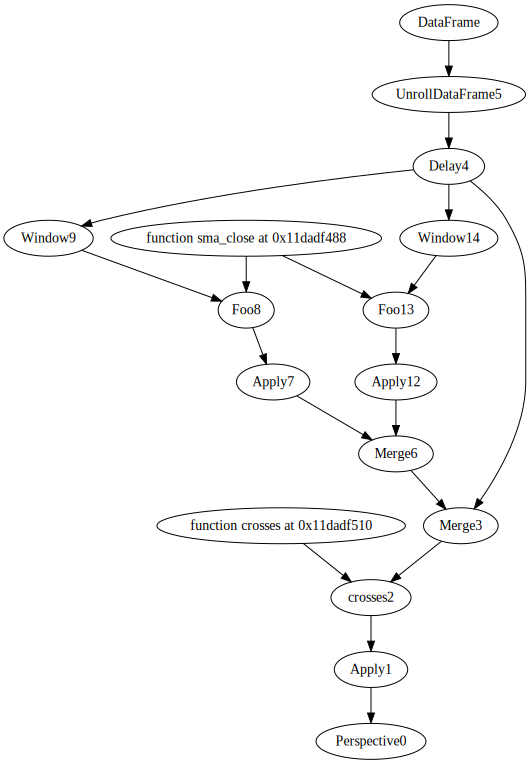

In [5]:
t.GraphViz(psp)